In [ ]:
_hex_param_projection_periods = 40

In [ ]:
_hex_param_interest_rate_lags = 10

# Replicating analysis of "Longer-run economic consequences of pandemics" [(Jorda, Singh, Taylor 2020)](https://www.frbsf.org/economic-research/publications/working-papers/2020/01/)
This notebook replicates the analysis of a recent working paper that demonstrates the historical impact 
of major pandemic event on interest rates across Europe. 

## Replicating European raw and natural real rate of interest time series
The first step is to replicate the natural interest rate time series using the Kalman filter and maximum likelihood 
optimization applied to a GDP weighted measure of the real rate of interest across Europe.

The raw real interest rate data and GDP weightings come from "Eight centuries of global real interest rates, RG, and 
the âsuprasecularâdecline, 1311â2018" [(Schmelzing 2020)](https://www.bankofengland.co.uk/working-paper/2020/eight-centuries-of-global-real-interest-rates-r-g-and-the-suprasecular-decline-1311-2018)

![](https://firebasestorage.googleapis.com/v0/b/firescript-577a2.appspot.com/o/imgs%2Fapp%2Fwhoisnnamdi%2FsEf-axjueT?alt=media&token=2444c9f4-2c8c-43a9-bcf2-a4832abc7090)

In [ ]:
# Need statsmodels for local projection regressions
!pip install statsmodels

In [ ]:
# Clone pyflux from repo since normal pip install is broken
!git clone https://github.com/RJT1990/pyflux.git

fatal: destination path 'pyflux' already exists and is not an empty directory.


In [ ]:
# pip install pyflux from git directory, which we'll use for the Kalman filter
!pip install pyflux/

Processing ./pyflux


 \

 |

 /

 -

 \

 |

 /

 -

 \

 |

 /

 -

 \

 |

 /

 -

 \

 |

 /

 -

 done
  Created wheel for pyflux: filename=pyflux-0.4.17-cp37-cp37m-linux_x86_64.whl size=6256525 sha256=47f8c4c3246e3b7143cf6b0678f871986ed7e3a2906936899c6b920609d3a97c


  Stored in directory: /tmp/pip-ephem-wheel-cache-enpsf0ok/wheels/63/96/22/718669d969459b05fabff525a9a1777e2550ec9b9f94dad6d0
Successfully built pyflux


  Attempting uninstall: pyflux
    Found existing installation: pyflux 0.4.17
    Uninstalling pyflux-0.4.17:
      Successfully uninstalled pyflux-0.4.17


In [ ]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import altair as alt
import pyflux as pf
%matplotlib inline

In [ ]:
# Read in GDP shares and interest rate data
gdp_shares = pd.read_excel("data.xlsx", sheet_name="III. GDP shares, 1310-2018", header=1)
rates = pd.read_excel("data.xlsx", sheet_name="IV. Country level, 1310-2018", header=1)

In [ ]:
# Rename Holland to tie to column name in rates data, also get rid of the "/"
gdp_shares = gdp_shares.rename({"Holland/NL": "Holland"}, axis=1)

# European countries to calculate weighted interest rate
eu_countries = ["Italy", "UK", "Holland", "Germany", "France", "Spain"]

# Dropped unneeded rows and columns
gdp_shares = gdp_shares[["Year"] + eu_countries].drop([1, 713]).dropna(how="all").reset_index(drop=True)

rates = rates[["Year"] + eu_countries].dropna(how="all").reset_index(drop=True)

gdp_shares = gdp_shares.astype({"Year": "int32"})
rates = rates.astype({"Year": "int32"})

In [ ]:
gdp_shares

,Year,Italy,UK,Holland,Germany,France,Spain
0,1310,0.796542,0.203458,0.000000,0.000000,0.000000,NaN
1,1311,0.796542,0.203458,0.000000,0.000000,0.000000,NaN
2,1312,0.796542,0.203458,0.000000,0.000000,0.000000,NaN
3,1313,0.796542,0.203458,0.000000,0.000000,0.000000,NaN
4,1314,0.796542,0.203458,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...
704,2014,0.0598576,0.074818,0.021254,0.088595,0.073608,0.041258
705,2015,0.0598576,0.074818,0.021254,0.088595,0.073608,0.041258
706,2016,0.0598576,0.074818,0.021254,0.088595,0.073608,0.041258
707,2017,0.0598576,0.074818,0.021254,0.088595,0.073608,0.041258


In [ ]:
rates

,Year,Italy,UK,Holland,Germany,France,Spain
0,1310,NaN,NaN,NaN,NaN,NaN,NaN
1,1311,NaN,NaN,NaN,NaN,NaN,NaN
2,1312,NaN,NaN,NaN,NaN,NaN,NaN
3,1313,NaN,NaN,NaN,NaN,NaN,NaN
4,1314,22.099135,13.430975,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
704,2018,1.640000,0.169000,-0.305,-0.350,0.327,1.760
705,2018,1.566000,0.901000,0.194,0.126,0.955,2.281
706,2018,1.891000,-0.390000,0.006,-0.302,0.475,1.552
707,2018,0.743000,-2.360000,-0.849,-1.090,-0.258,-0.425


In [ ]:
# Calculate weighted average interest rate using GDP shares
eu_rate = pd.concat(
        [rates["Year"], (rates[eu_countries] * gdp_shares[eu_countries]).sum(axis=1) / gdp_shares[eu_countries].sum(axis=1)], 
        axis=1
    ).rename({0: "Percent"}, axis=1)

# Drop years before 1315 since they don't have interest rate data
eu_rate = eu_rate[eu_rate["Year"] >= 1315].reset_index(drop=True)

In [ ]:
# Run Kalmarn filter using maximum likelihood to fit latent noise variables
model = pf.LLEV(data=eu_rate, target="Percent")
results = model.fit()
results.summary()

LLEV                                                                                                      
======================================================= ==================================================
Dependent Variable: Percent                             Method: MLE                                       
Start Date: 0                                           Log Likelihood: -2444.1207                        
End Date: 703                                           AIC: 4892.2414                                    
Number of observations: 704                             BIC: 4901.3549                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Sigma^2 irregular                        56.9513897                                                       
Sigma^2 level                        

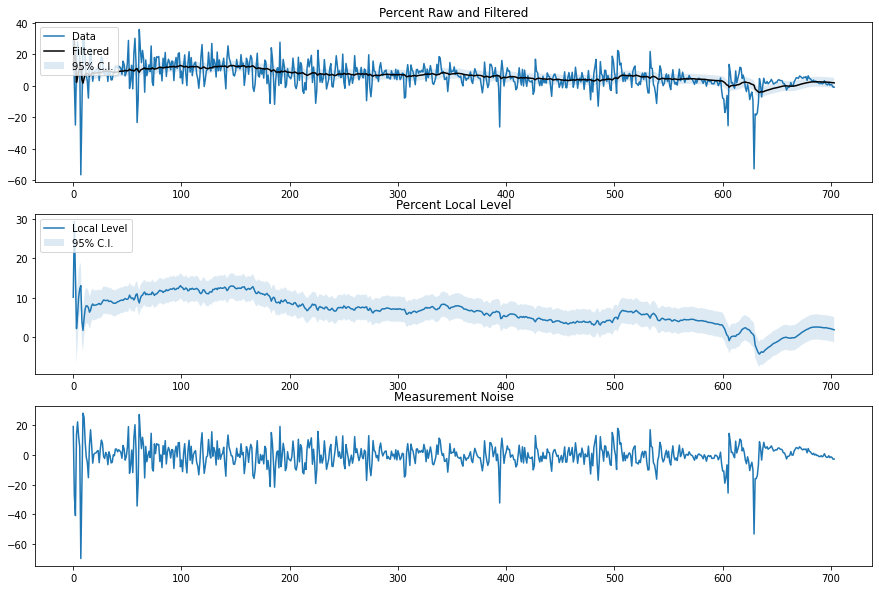

In [ ]:
# Plot filtered natural rate of interest from Kalmar filter
model.plot_fit(figsize=(15,10), series_type="Filtered")

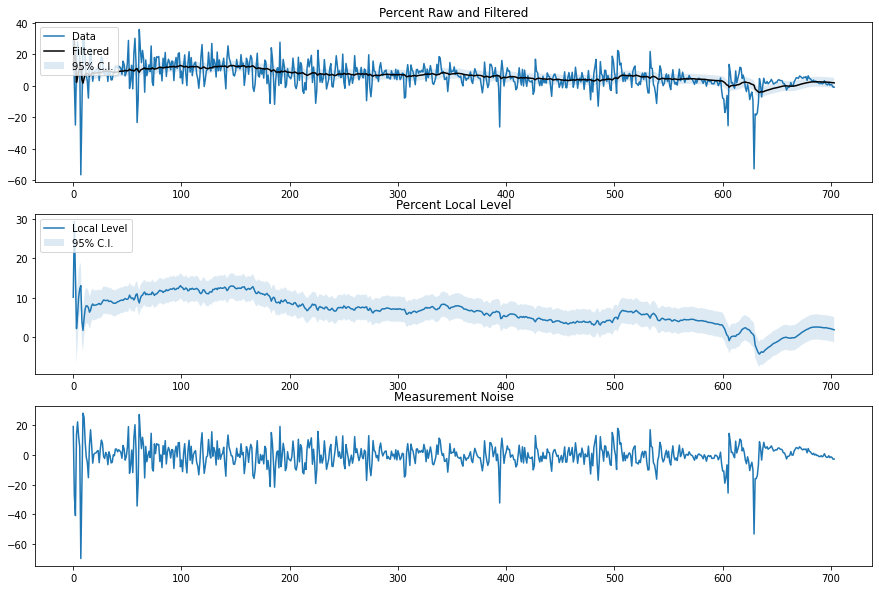

In [ ]:
# Plot filtered natural rate of interest from Kalmar filter
model.plot_fit(figsize=(15,10), series_type="Filtered")

In [ ]:
# Extract natural interest rate from kalman filer model, add dates
mu = model._model(eu_rate["Percent"].values, model.latent_variables.get_z_values())[0]
mu = mu.reshape(-1)[:-1]
natural = pd.concat([pd.DataFrame(data=mu, columns=["real"]), pd.DataFrame(data=range(1315,2019), columns=["Year"])], axis=1)

In [ ]:
# Plot weighted real interest rate and natural interest rate estimate
x_axis = alt.Axis(
    labelSeparation=10,
    labelAngle=0,
    ticks=False
)

raw_real = alt.Chart(
            eu_rate,
            title="Figure 1: The European real natural rate of interest, 1315-2018"
        ).mark_line().encode(
            alt.X("Year", type="ordinal", axis=x_axis),
            alt.Y("Percent", title="Percent"),
        ).properties(width=500)

natural_real = alt.Chart(natural).mark_line(color="red").encode(
    alt.X("Year", type="ordinal", axis=x_axis),
    y="real"
)

rule = alt.Chart(pd.DataFrame(data=[0], columns=["Zero"])).mark_rule(color='black').encode(
    alt.Y("Zero")
)

raw_real + natural_real + rule

alt.LayerChart(...)

## Replicating local projection analysis of the impact of large pandemic events
We now replicate the analysis using the local projection method of [(Jorda 2005)](https://www.jstor.org/stable/4132675)

Below is the original estimated path of the European real natural rate of interest in the years following a major pandemic

![](https://firebasestorage.googleapis.com/v0/b/firescript-577a2.appspot.com/o/imgs%2Fapp%2Fwhoisnnamdi%2FZLNjNotivI?alt=media&token=c7b8fecc-9447-4588-a130-bac0ad02a637)

Pandemic data from [(Jorda, Singh, Taylor 2020)](https://www.frbsf.org/economic-research/publications/working-papers/2020/01/)
![](https://firebasestorage.googleapis.com/v0/b/firescript-577a2.appspot.com/o/imgs%2Fapp%2Fwhoisnnamdi%2FXR2GrfC6it?alt=media&token=0af6dc7c-1cbb-421a-894b-7332c7406585)

In [ ]:
pandemics = [[
                "Black Death", 
                "Great Plague of London", 
                "First Asia Europe Cholera Pandemic", 
                "Second Asia Europe Cholera Pandemic",
                "Russia Cholera Pandemic",
                "Global Flu Pandemic",
                "Sixth Cholera Pandemic",
                "Encephalitis Lethargic Pandemic",
                "Spanish Flu",
                "Asian Flu",
                "Hong Kong Flu",
                "H1N1 Pandemic"
             ],
             [
                 1353,
                 1666,
                 1826,
                 1851,
                 1860,
                 1890,
                 1923,
                 1926,
                 1920,
                 1958,
                 1969,
                 2009
             ],
             [
                 75000000,
                 100000,
                 100000,
                 100000,
                 1000000,
                 1000000,
                 800000,
                 1500000,
                 100000000,
                 2000000,
                 1000000,
                 203000
             ]]

In [ ]:
pandemics = np.reshape([y for x in pandemics for y in x], (3, 12))
pandemics = pd.DataFrame(pandemics.T, columns=["Event", "End", "Deaths"])

In [ ]:
pandemics

,Event,End,Deaths
0,Black Death,1353,75000000
1,Great Plague of London,1666,100000
2,First Asia Europe Cholera Pandemic,1826,100000
3,Second Asia Europe Cholera Pandemic,1851,100000
4,Russia Cholera Pandemic,1860,1000000
5,Global Flu Pandemic,1890,1000000
6,Sixth Cholera Pandemic,1923,800000
7,Encephalitis Lethargic Pandemic,1926,1500000
8,Spanish Flu,1920,100000000
9,Asian Flu,1958,2000000


In [ ]:
# Setup design matrix to be used in regressions, rename columns appropriately
design_matrix = natural.copy()
design_matrix["P_t"] = design_matrix["Year"].isin(pandemics["End"])
design_matrix = design_matrix.rename({"real": "r_t", "Year": "t"}, axis=1)

In [ ]:
design_matrix

,r_t,t,P_t
0,10.146267,1315,False
1,29.304830,1316,False
2,15.862462,1317,False
3,2.223124,1318,False
4,5.676118,1319,False
...,...,...,...
699,2.252110,2014,False
700,2.175063,2015,False
701,2.121939,2016,False
702,2.048887,2017,False


We need to set the data up to match the following regression specification:

$$r_{t+h}^{*}-r_{t}^{*}=\alpha^{h}+\beta^{h} P_{t}+\sum_{l=1}^{L} \rho_{l}^{h} r_{t-l}^{*}+e_{t+h}^{h} ; h=1, \ldots, H$$

In [ ]:
# Create outcome variables representing change in natural rate of interest since time t
for i in range(1,41):
    design_matrix["delta_r_t_"+str(i)] = design_matrix["r_t"].shift(-i) - design_matrix["r_t"]

# Create lagged natural rate of interest variables to serve as controls
for i in range(1,11):
    design_matrix["r_t_"+str(i)] = design_matrix["r_t"].shift(i)

In [ ]:
design_matrix.head(20)

,r_t,t,P_t,delta_r_t_1,delta_r_t_2,delta_r_t_3,delta_r_t_4,delta_r_t_5,delta_r_t_6,delta_r_t_7,...,r_t_1,r_t_2,r_t_3,r_t_4,r_t_5,r_t_6,r_t_7,r_t_8,r_t_9,r_t_10
0,10.146267,1315,False,19.158563,5.716195,-7.923143,-4.470149,0.039108,2.107317,2.909632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29.304830,1316,False,-13.442367,-27.081706,-23.628711,-19.119455,-17.051245,-16.248931,-25.256621,...,10.146267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.862462,1317,False,-13.639338,-10.186344,-5.677087,-3.608878,-2.806563,-11.814254,-14.087017,...,29.304830,10.146267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.223124,1318,False,3.452994,7.962251,10.030460,10.832775,1.825085,-0.447678,2.519695,...,15.862462,29.304830,10.146267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.676118,1319,False,4.509256,6.577466,7.379781,-1.627910,-3.900673,-0.933300,1.514583,...,2.223124,15.862462,29.304830,10.146267,NaN,NaN,NaN,NaN,NaN,NaN
5,10.185375,1320,False,2.068210,2.870524,-6.137166,-8.409929,-5.442556,-2.994674,-2.175232,...,5.676118,2.223124,15.862462,29.304830,10.146267,NaN,NaN,NaN,NaN,NaN
6,12.253584,1321,False,0.802315,-8.205376,-10.478139,-7.510766,-5.062883,-4.243442,-4.345561,...,10.185375,5.676118,2.223124,15.862462,29.304830,10.146267,NaN,NaN,NaN,NaN
7,13.055899,1322,False,-9.007690,-11.280453,-8.313080,-5.865198,-5.045756,-5.147876,-5.540324,...,12.253584,10.185375,5.676118,2.223124,15.862462,29.304830,10.146267,NaN,NaN,NaN
8,4.048209,1323,False,-2.272763,0.694610,3.142492,3.961934,3.859814,3.467366,2.316778,...,13.055899,12.253584,10.185375,5.676118,2.223124,15.862462,29.304830,10.146267,NaN,NaN
9,1.775445,1324,False,2.967373,5.415255,6.234697,6.132577,5.740129,4.589541,5.071564,...,4.048209,13.055899,12.253584,10.185375,5.676118,2.223124,15.862462,29.304830,10.146267,NaN


In [ ]:
# Helper function that will run our local projection regressions based on supplied parameters
def local_projection(data=None, h=1, lags=0):

    lag_vars = ""

    for i in [" + r_t_" + str(lag+1) for lag in range(lags)]:
        lag_vars+= i

    formula = "delta_r_t_" + str(h) + " ~ P_t" + lag_vars

    model = ols(formula=formula, data=data)

    results = model.fit()

    #print(results.get_robustcov_results(cov_type="HC1").summary())

    return results.params["P_t[T.True]"]

In [ ]:
betas = []

for i in range(1, _hex_param_projection_periods):
    betas.append(local_projection(design_matrix, i, _hex_param_interest_rate_lags))

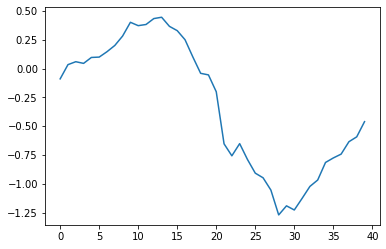

In [ ]:
plt.plot(betas)